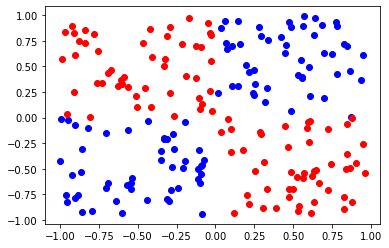

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.cm as cm
from matplotlib import pyplot as plt
#plt.style.use('ggplot')
N=200
x=[]
yt=[]
for i in range(N//4):
    x.append( [0+np.random.rand(), 0+np.random.rand()])
    x.append( [-1+np.random.rand(), -1+np.random.rand()])
    yt.append([0 , 1])
    yt.append([0 , 1])

for i in range(N//4):
    x.append( [0+np.random.rand(), -1+np.random.rand()])
    x.append( [-1+np.random.rand(), 0+np.random.rand()])
    yt.append([1 , 0])
    yt.append([1 , 0])
    
x=np.array(x)
yt=np.array(yt)

plt.plot( x[yt[:,1]==1,0], x[yt[:,1]==1,1], 'ob')
plt.plot( x[yt[:,0]==1,0], x[yt[:,0]==1,1], 'or')

<img src="decision_tree.png">

In [2]:
def gini_l(x,yt,dim,t):
    L=x[:,dim]<t
    yt[L]
    p=np.sum(yt[L],axis=0)/(np.sum(yt[L])+00.1)
    return 1-np.sum(p*p)

def gini_r(x,yt,dim,t):
    R=x[:,dim]>=t
    yt[R]
    p=np.sum(yt[R],axis=0)/(np.sum(yt[R])+00.1)
    return 1-np.sum(p*p)

def gini(y):
    p=np.sum(y,axis=0)/(np.sum(y)+1e-3)
    return 1-np.sum(p*p)

class Node(object):
    def __init__(self,x,y, min_size=2,depth=0,side='_'):
        self.x=x
        self.y=y
        self.depth=depth
        self.side=side
        self.score=gini(self.y)
        self.n=self.x.shape[0]
        self.min_size=min_size
    
    def find_threshold(self, dim):
        n=self.n
        #print('n: ',n)
        gains=np.zeros(n)
        for i in range(n):
            th=self.x[i,dim]
            L=self.x[:,dim]<th
            R= ~L
            new_gini=np.sum(L)/n*gini(self.y[L])+np.sum(R)/n*gini(self.y[R])
            gain=self.score-new_gini
            gains[i]=gain
            #print('i:%s dim:%s th:%s score:%.3f new_gini:%.3f'%(i,dim,th,self.score,new_gini))
        #print('gains: ',gains)
        ix=np.argmax(gains)
        #print('ix',ix)
        score=gains[ix]
        threshold=self.x[ix,dim]
        #print('dim:%s threshold:%.3f score:%.3f'%(dim,threshold,gains[ix]))
        return threshold,score,gains
    
    def split(self, dim, threshold):
        L=self.x[:,dim]<threshold
        R=self.x[:,dim]>=threshold
        self.L=Node(self.x[L,:],self.y[L,:] , depth=self.depth+1,side='L')
        self.R=Node(self.x[R,:],self.y[R,:] , depth=self.depth+1,side='R')
        
    def fit(self):
        #print('%s depth:%s size:%s'%(self.side, self.depth, self.n))
        dim=np.random.randint(self.x.shape[1])
        threshold,score,_=self.find_threshold(dim)
        self.dim=dim
        self.threshold=threshold
        self.score=score
        self.p=np.sum(self.y,axis=0)#/(np.sum(self.y))
        print(self)
        if self.n<=self.min_size:
            print('----min size')
        elif score<1e-3:
            print('----no improve')
        else:
            self.split(dim,threshold)
            self.L.fit()
            self.R.fit()
    
    def __str__(self):
        return '%s depth:%s dim:%s size:%s threshold:%.3f score:%.3f p:%s'\
            %(self.side, self.depth, self.dim, self.n,self.threshold, self.score, self.p)
    
    def predict(self,x):
        #print(self)
        if not hasattr(self, 'L'):
            return self.p
        if x[0,self.dim]<self.threshold:
            pout=self.L.predict(x)
        else:
            pout=self.R.predict(x)
        return pout

In [3]:
root=Node(x,yt,min_size=10)
root.fit()

_ depth:0 dim:0 size:200 threshold:0.949 score:0.005 p:[100 100]
L depth:1 dim:1 size:198 threshold:0.882 score:0.012 p:[ 98 100]
L depth:2 dim:0 size:184 threshold:0.466 score:0.011 p:[95 89]
L depth:3 dim:1 size:134 threshold:-0.009 score:0.108 p:[63 71]
L depth:4 dim:1 size:65 threshold:-0.822 score:0.020 p:[15 50]
L depth:5 dim:1 size:8 threshold:-0.882 score:0.300 p:[4 4]
L depth:6 dim:0 size:5 threshold:0.117 score:0.319 p:[1 4]
L depth:7 dim:0 size:4 threshold:-0.856 score:0.000 p:[0 4]
----no improve
R depth:7 dim:1 size:1 threshold:-0.935 score:0.000 p:[1 0]
----min size
R depth:6 dim:1 size:3 threshold:-0.882 score:0.000 p:[3 0]
----no improve
R depth:5 dim:0 size:57 threshold:0.034 score:0.311 p:[11 46]
L depth:6 dim:1 size:46 threshold:-0.822 score:0.000 p:[ 0 46]
----no improve
R depth:6 dim:1 size:11 threshold:-0.759 score:0.000 p:[11  0]
----no improve
R depth:4 dim:1 size:69 threshold:0.156 score:0.028 p:[48 21]
L depth:5 dim:0 size:9 threshold:-0.952 score:0.000 p:[9 0

In [4]:
root.predict(np.array([[0.5,0.5]]))

array([ 0, 18])

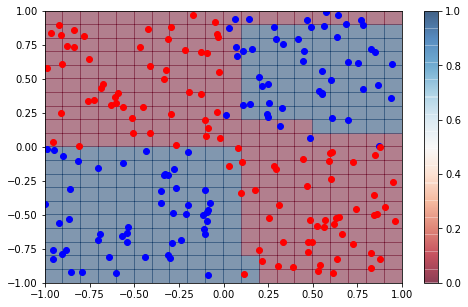

In [6]:
my,mx=np.mgrid[slice(-1,1.1,0.1),slice(-1,1.1,0.1)]
out=np.zeros(mx.shape)
for i in range(mx.shape[0]):
    for j in range(mx.shape[1]):
        x1=mx[i,j]
        x2= my[i,j]
        u=np.array([[ x1, x2]])
        #forward
        p=root.predict(u)
        out[i,j]=np.argmax(p)
fig = plt.figure(figsize=(8,5))
plt.pcolor(mx,my,out,cmap=cm.RdBu,alpha=0.5, edgecolor='none')
plt.colorbar()
plt.plot( x[yt[:,1]==1,0], x[yt[:,1]==1,1], 'ob')
plt.plot( x[yt[:,0]==1,0], x[yt[:,0]==1,1], 'or')